In [1]:
!pip -q install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 49.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!wget https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-v1-5/resolve/main/tokenizer/merges.txt
!wget https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-v1-5/resolve/main/tokenizer/vocab.json
!wget https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-v1-5/resolve/main/v1-5-pruned-emaonly.ckpt

!mkdir /content/data
!mv -t /content/data/ /content/merges.txt /content/v1-5-pruned-emaonly.ckpt /content/vocab.json

# data folder = /content/data
# images path =
# cow images path = /content/drive/MyDrive/Projects/Stable Diffusion From Scratch/cow_images


--2025-03-09 21:27:05--  https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-v1-5/resolve/main/tokenizer/merges.txt
Resolving huggingface.co (huggingface.co)... 18.164.174.118, 18.164.174.17, 18.164.174.23, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 524619 (512K) [text/plain]
Saving to: ‘merges.txt’

merges.txt          100%[===================>] 512.32K  --.-KB/s    in 0.1s    

2025-03-09 21:27:05 (3.64 MB/s) - ‘merges.txt’ saved [524619/524619]

--2025-03-09 21:27:05--  https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-v1-5/resolve/main/tokenizer/vocab.json
Resolving huggingface.co (huggingface.co)... 18.164.174.55, 18.164.174.23, 18.164.174.118, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1059962 (1.0M) [text/plain]
Saving to: ‘vocab.json’

vocab.json          100%[========

Using device: cuda


100%|██████████| 45/45 [00:26<00:00,  1.71it/s]


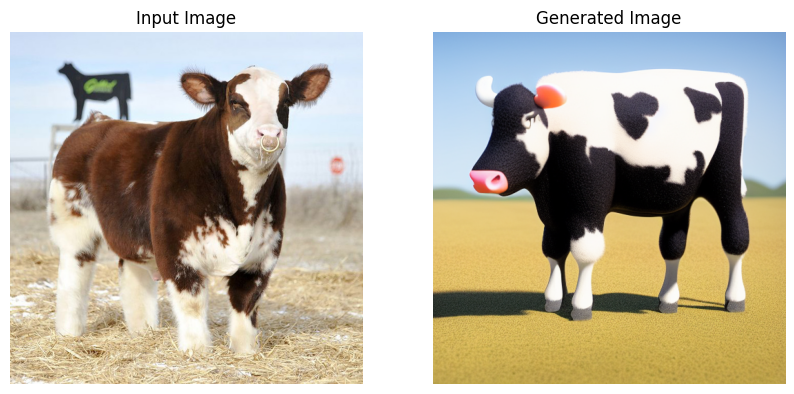

100%|██████████| 45/45 [00:27<00:00,  1.65it/s]


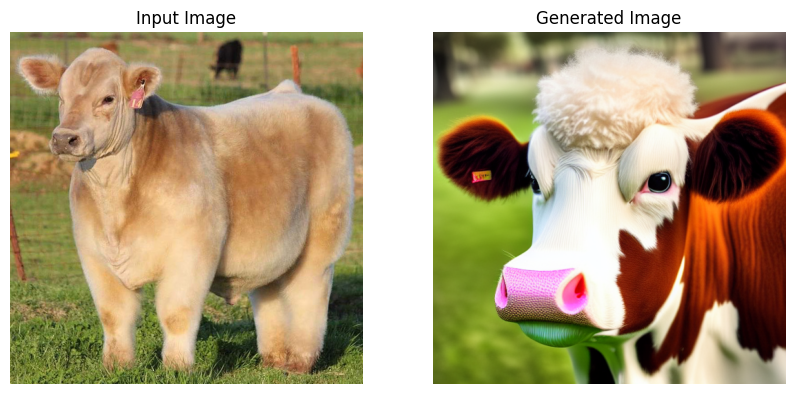

100%|██████████| 45/45 [00:26<00:00,  1.70it/s]


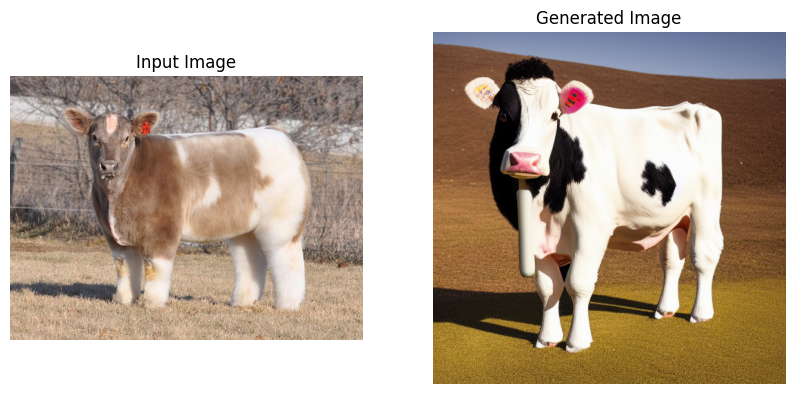

100%|██████████| 45/45 [00:26<00:00,  1.67it/s]


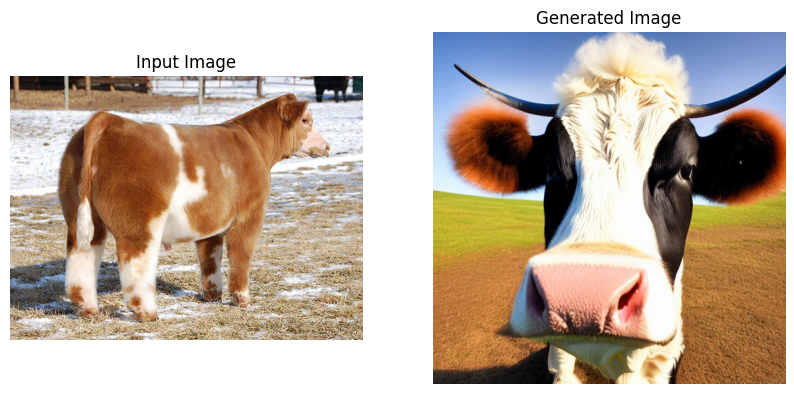

100%|██████████| 45/45 [00:26<00:00,  1.68it/s]


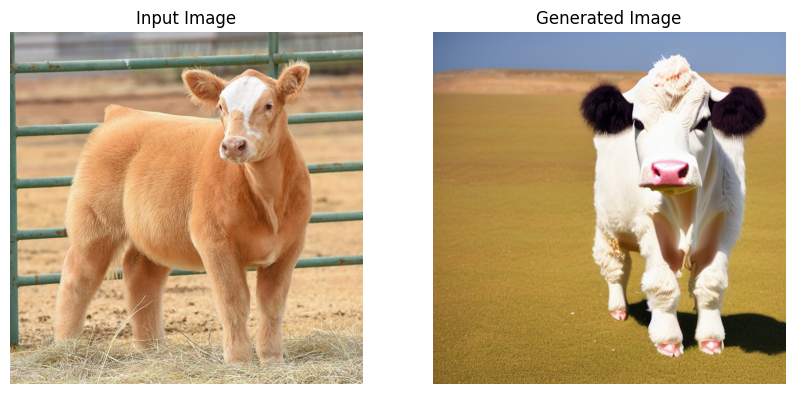

In [5]:
import model_loader
import pipeline
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch
import matplotlib.pyplot as plt

DEVICE = "cuda"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

tokenizer = CLIPTokenizer("/content/data/vocab.json", merges_file="/content/data/merges.txt")
model_file = "/content/data/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

## TEXT TO IMAGE

# prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
prompt = "A fluffy healthy cow, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

input_image = None
# Comment to disable image to image
image_paths = ["/content/drive/MyDrive/Projects/Stable Diffusion From Scratch/cow_images/washed-cow11.jpg",
               "/content/drive/MyDrive/Projects/Stable Diffusion From Scratch/cow_images/washed-cow15.jpg",
               "/content/drive/MyDrive/Projects/Stable Diffusion From Scratch/cow_images/washed-cow2.jpg",
               "/content/drive/MyDrive/Projects/Stable Diffusion From Scratch/cow_images/washed-cow6.jpg",
               "/content/drive/MyDrive/Projects/Stable Diffusion From Scratch/cow_images/washed-cow9.jpg"]

# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.9

## SAMPLER

sampler = "ddpm"
num_inference_steps = 50
seed = 42

for i in range(0, 5):
  input_image = Image.open(image_paths[i])

  output_image = pipeline.generate(
      prompt=prompt,
      uncond_prompt=uncond_prompt,
      input_image=input_image,
      strength=strength,
      do_cfg=do_cfg,
      cfg_scale=cfg_scale,
      sampler_name=sampler,
      n_inference_steps=num_inference_steps,
      seed=seed,
      models=models,
      device=DEVICE,
      idle_device="cpu",
      tokenizer=tokenizer,
  )

  # Combine the input image and the output image into a single image.
  Image.fromarray(output_image)
    # Display input and output images side by side
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(input_image)
  axes[0].set_title("Input Image")
  axes[0].axis("off")

  axes[1].imshow(output_image)
  axes[1].set_title("Generated Image")
  axes[1].axis("off")

  plt.show()